# Analysis of Nea. ancestry

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../code/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [59]:
suppressMessages(
array_snps <- load_dataset("../data/genotypes/ice_age.tsv",
                           "../data/genotypes/sgdp.tsv",
                           "../data/genotypes/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(setup="direct", Zscore=Inf)

Warning message:
“Unknown variables: ``”

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

Joining, by = "name"


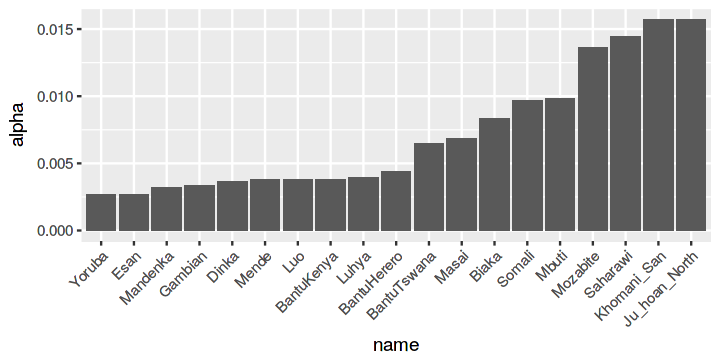

In [6]:
options(repr.plot.width=6, repr.plot.height=3)

inner_join(samples, direct_nea) %>% filter(pop == "Africa") %>% arrange(desc(alpha)) %>%
mutate(name=factor(name, levels=name[order(alpha)])) %>% 
ggplot(aes(name, alpha)) + geom_bar(stat="identity") + theme(axis.text.x=element_text(angle=45, hjust=1))

In [7]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [8]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [9]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai + new_Vindija
* O - Chimp


![](img/ice_age_f4_description.png)

In [11]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Denisova")))

In [12]:
iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                        prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

In [13]:
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
mende  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mende", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [104]:
merge_pops(IND_FILE, paste0(IND_FILE, ".Africans"),
           merge=list(Africans=c("Yoruba", "Mbuti", "Mende", "Dinka")))

In [108]:
africans  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Africans", O="Chimp", prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".Africans"))

In [14]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [220]:
results <- bind_rows(
    inner_join(bind_rows(iceage_Nea, mbuti,  yoruba, mende, dinka, africans), snp_counts_f4, by=c("X"="name")) %>% select(-c(A, B, C, O)),
    inner_join(direct_nea, snp_counts_direct) %>% rename(X=name)
) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(se=alpha / Zscore) %>%
    mutate(sites="BigYRI_HO")

Joining, by = "name"


# Plot Nea. estimates over time

In [191]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [221]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"),
                  !X %in% non_udg_samples,
                  !X %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                               "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                  !X %in% non_udg_samples)

In [195]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(eur_nea,
           setup == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * se, ymax=alpha + x * se, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > x), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlab("age [years before present]") + ylab("Neanderthal ancestry proportion") +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) #+
        #ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(eur_nea,
           setup == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) }
}

## Results from the Ice Age paper

In [211]:
cutoff <- 200000

In [196]:
options(repr.plot.width=9, repr.plot.height=5)

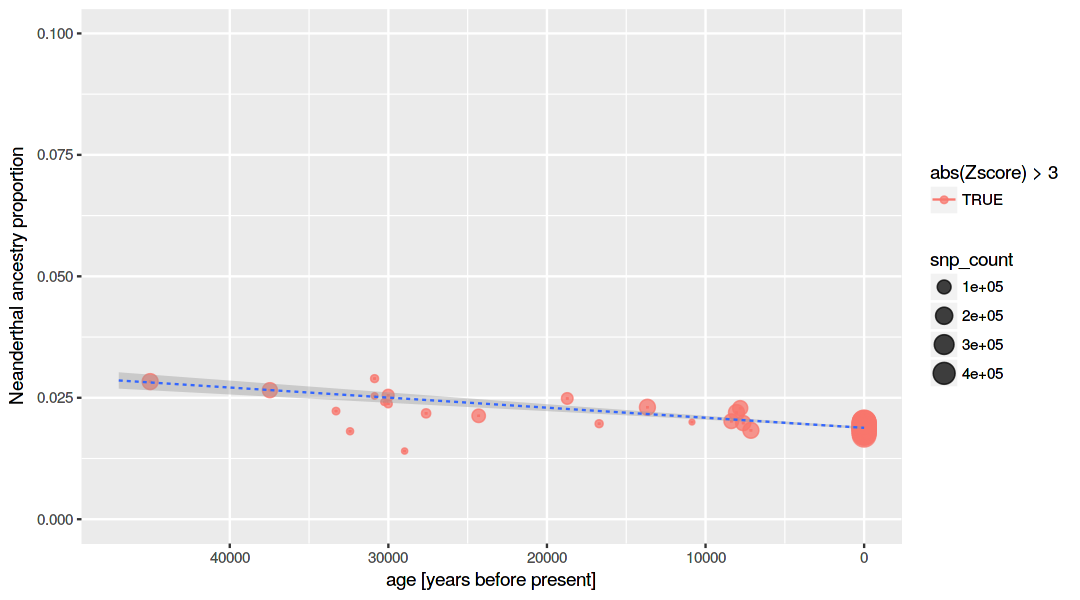

In [197]:
plot_nea_vs_time("direct")

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

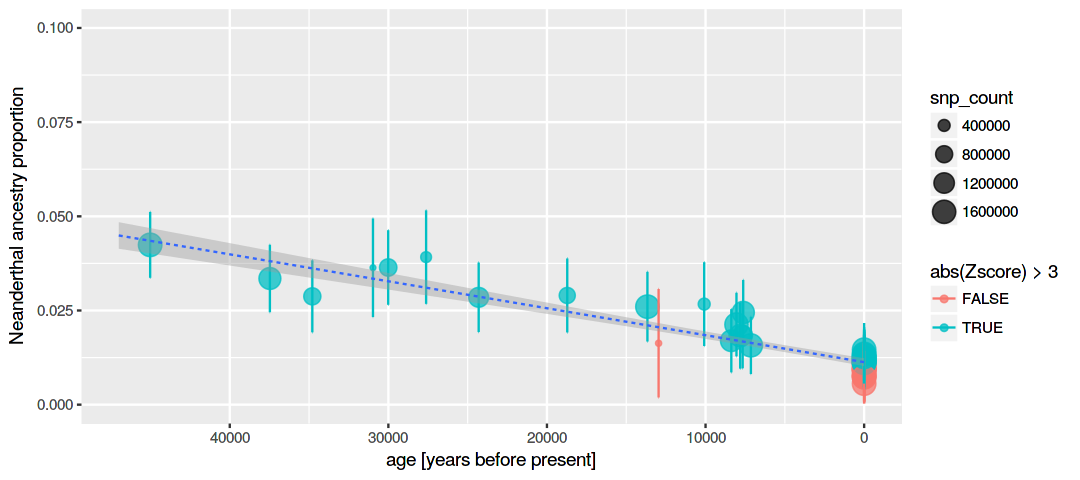

In [212]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp", ylim=c(0, 0.1), snp_cutoff=cutoff)

# New f4 results

In [199]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-8824260 -7257609 -5724366  3274766 49501561 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -4192      16559  -0.253    0.801
.[["alpha"]]   429393     727128   0.591    0.558

Residual standard error: 13430000 on 41 degrees of freedom
Multiple R-squared:  0.008434,	Adjusted R-squared:  -0.01575 
F-statistic: 0.3487 on 1 and 41 DF,  p-value: 0.5581



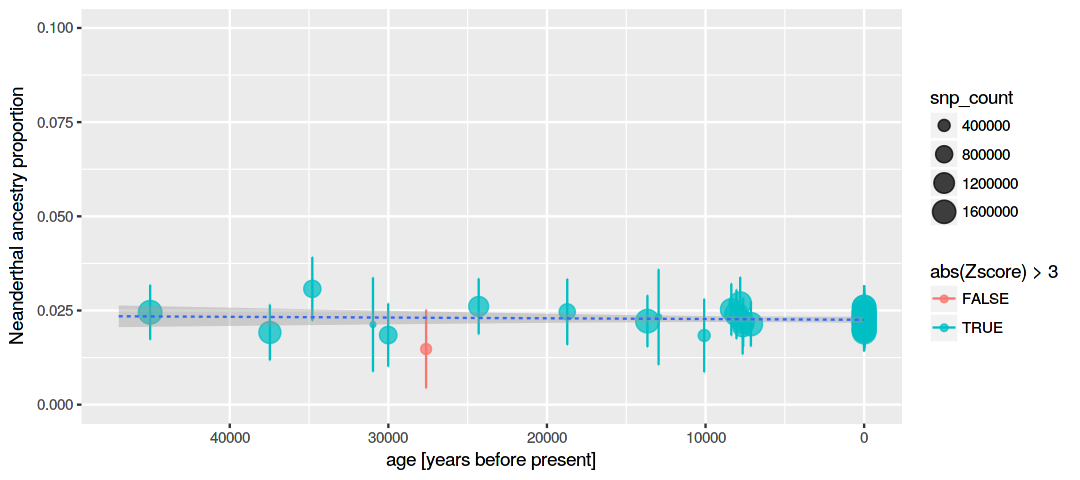

In [213]:
"qpF4ratio__new_Altai_new_Vindija_Africans_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7619953 -7132670 -6616100  3139506 50197292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      2627      15138   0.174    0.863
.[["alpha"]]   138703     717713   0.193    0.848

Residual standard error: 13480000 on 41 degrees of freedom
Multiple R-squared:  0.0009101,	Adjusted R-squared:  -0.02346 
F-statistic: 0.03735 on 1 and 41 DF,  p-value: 0.8477



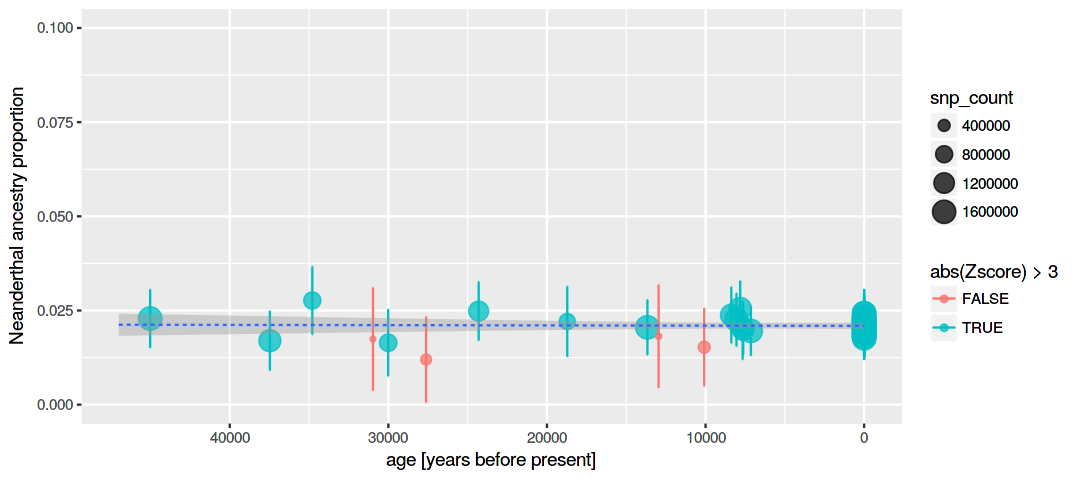

In [214]:
"qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-10605211  -7320313  -4138319   3487237  48575242 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    -15252      16362  -0.932    0.357
.[["alpha"]]   881189     689876   1.277    0.209

Residual standard error: 13220000 on 41 degrees of freedom
Multiple R-squared:  0.03827,	Adjusted R-squared:  0.01481 
F-statistic: 1.632 on 1 and 41 DF,  p-value: 0.2087



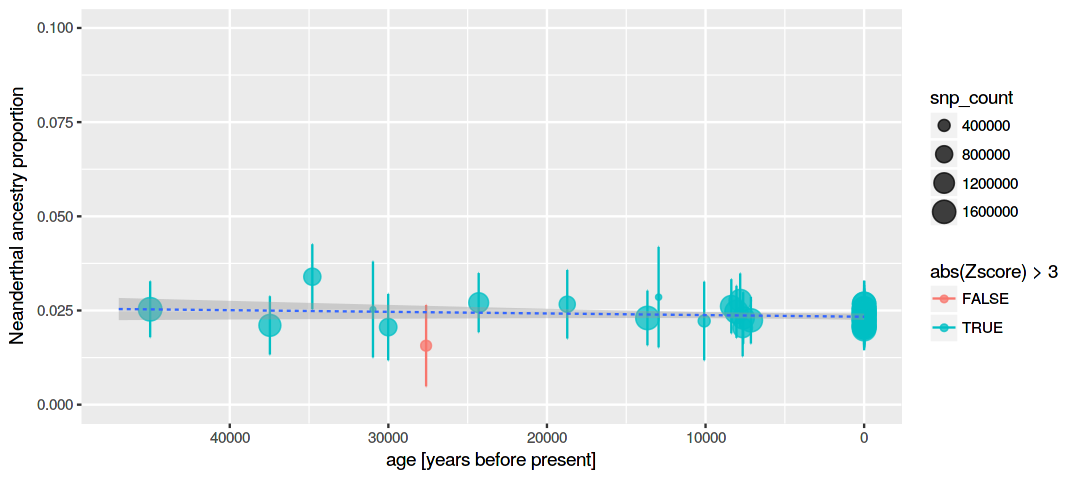

In [215]:
"qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7650616 -7145752 -6606175  3228516 50170379 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      1986      18164   0.109    0.913
.[["alpha"]]   143496     731528   0.196    0.845

Residual standard error: 13480000 on 41 degrees of freedom
Multiple R-squared:  0.0009376,	Adjusted R-squared:  -0.02343 
F-statistic: 0.03848 on 1 and 41 DF,  p-value: 0.8455



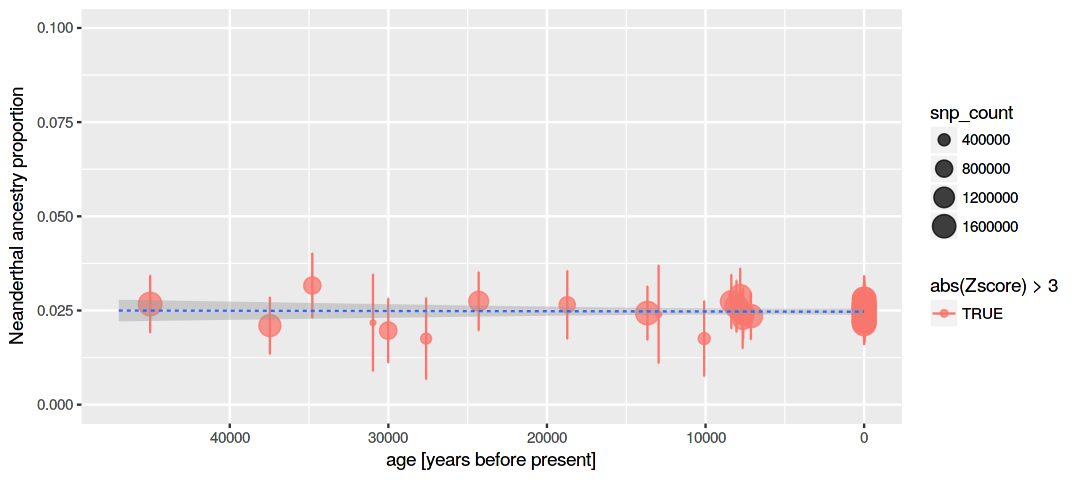

In [216]:
"qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9700178 -7305302 -4954208  3422626 48947091 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -8606      15549  -0.553    0.583
.[["alpha"]]   654983     715831   0.915    0.366

Residual standard error: 13350000 on 41 degrees of freedom
Multiple R-squared:  0.02001,	Adjusted R-squared:  -0.003891 
F-statistic: 0.8372 on 1 and 41 DF,  p-value: 0.3655



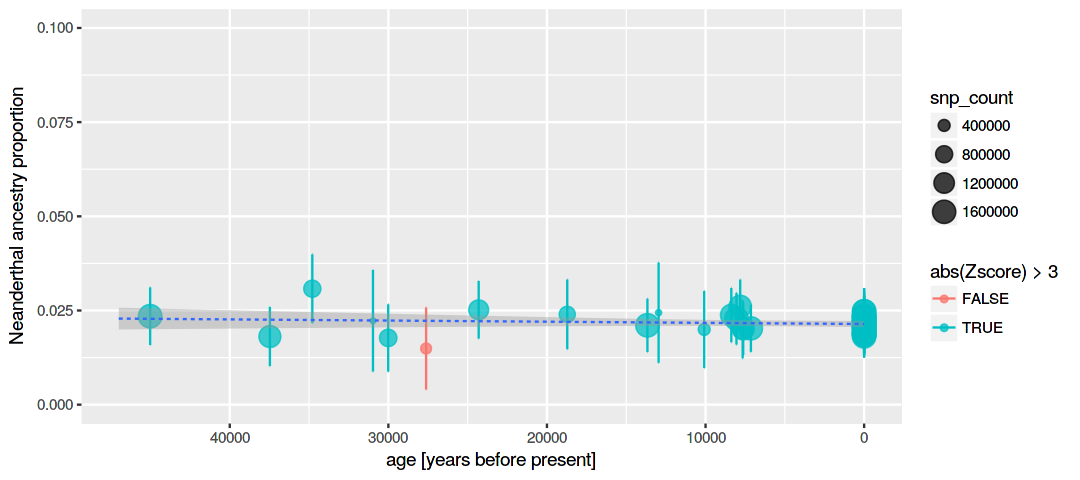

In [217]:
"qpF4ratio__new_Altai_new_Vindija_Mende_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}

## Europeans vs East Asians

In [205]:
options(repr.plot.width=9, repr.plot.height=4)

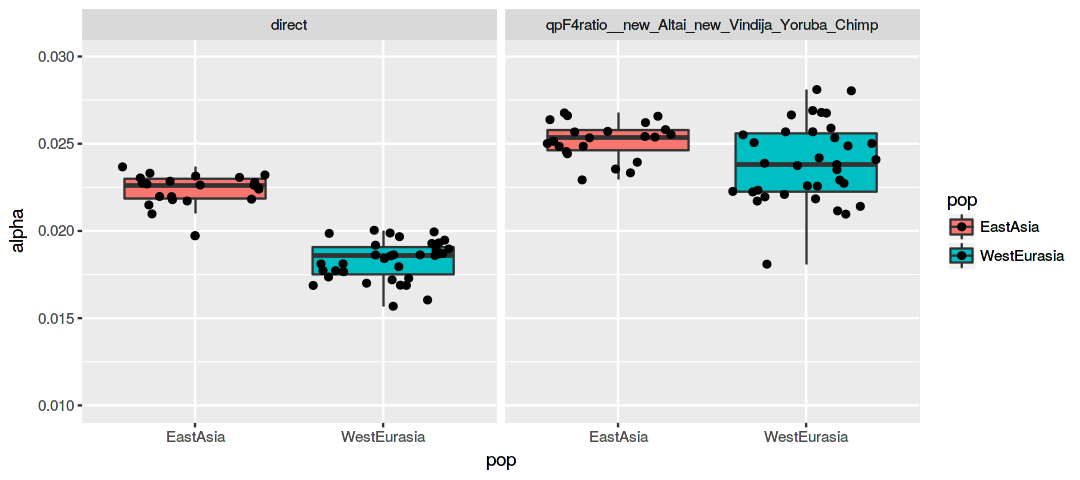

In [206]:
filter(results,
       pop %in% c("WestEurasia", "EastAsia"),
       setup %in% c("direct", "qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")) %>%
ggplot(aes(pop, alpha, fill=pop)) + geom_boxplot() + geom_jitter() + facet_grid(~ setup) +
ylim(0.01, 0.03)

# Write the admixture array estimates

In [207]:
eur_nea %>%
    filter(setup == "direct") %>%
    select(name=X, age, nea=alpha, pop, snp_count) %>%
    write_tsv("../data/admixture_array_nea.tsv")

In [222]:
saveRDS(filter(eur_nea, setup != "direct", snp_count > cutoff), "../data/RData/admixtools_nea_ancestry-both_arrays.rds")